<a href="https://colab.research.google.com/github/fikran03/Kelompok_Boboiboy_Halilintar_NLP_Hewan_Laut/blob/main/HEWAN_LAUT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving datalaut.pdf to datalaut (1).pdf
Masukkan pertanyaan Anda: Apa manfaat dari konservasi hewan laut yang dilindungi di Papua?


Some weights of AlbertForQuestionAnswering were not initialized from the model checkpoint at indobenchmark/indobert-lite-large-p2 and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Error dengan model indobenchmark: not a string
Menggunakan model alternatif xlm-roberta-base


Some weights of XLMRobertaForQuestionAnswering were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Jawaban yang dihasilkan: keanekaragaman hayati, keseimbangan ekosistem laut, peningkatan 
ekowisata,
BERTScore Precision: 0.89
BERTScore Recall: 0.74
BERTScore F1: 0.80


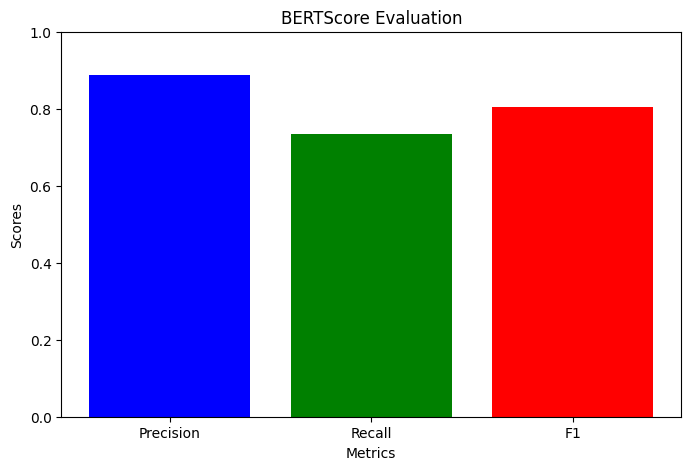

In [ ]:
import fitz  # PyMuPDF
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from transformers import pipeline
from bert_score import score
import matplotlib.pyplot as plt

# Fungsi untuk mengekstrak teks dari PDF
def extract_text_from_pdf(pdf_path):
    doc = fitz.open(pdf_path)
    text = ""
    for page_num in range(len(doc)):
        page = doc.load_page(page_num)
        text += page.get_text()
    return text

# Mengunggah file PDF (gunakan metode yang sesuai jika di Colab)
from google.colab import files
uploaded = files.upload()
pdf_path = list(uploaded.keys())[0]

# Mengekstrak teks dari PDF
text = extract_text_from_pdf(pdf_path)

# Membagi teks menjadi halaman untuk dimasukkan ke FAISS
pages = [{"page_content": page} for page in text.split("\n\n")]

# Menginisialisasi model sentence-transformers
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

# Mendapatkan embeddings untuk setiap halaman
embeddings = model.encode([page['page_content'] for page in pages])

# Fungsi untuk melakukan pencarian kesamaan
def similarity_search(query, embeddings, pages, model, top_k=5):
    query_embedding = model.encode([query])
    similarities = cosine_similarity(query_embedding, embeddings)
    top_k_indices = np.argsort(similarities[0])[-top_k:][::-1]
    return [pages[i] for i in top_k_indices]

# Melakukan pencarian kesamaan
query = input("Masukkan pertanyaan Anda: ")
docs = similarity_search(query, embeddings, pages, model)

# Menggabungkan konten yang relevan
content = "\n".join([x["page_content"] for x in docs])

# Menggunakan pipeline QA Hugging Face
try:
    qa_model = pipeline("question-answering", model="indobenchmark/indobert-lite-large-p2", tokenizer="indobenchmark/indobert-lite-large-p2")
except Exception as e:
    print(f"Error dengan model indobenchmark: {e}")
    print("Menggunakan model alternatif xlm-roberta-base")
    qa_model = pipeline("question-answering", model="xlm-roberta-base", tokenizer="xlm-roberta-base")

# Melakukan inferensi
qa_input = {"question": query, "context": content}
result = qa_model(qa_input)
generated_answer = result['answer']

# Menampilkan jawaban yang dihasilkan
print("Jawaban yang dihasilkan:", generated_answer)

# Jawaban referensi (ganti ini dengan jawaban yang benar untuk evaluasi)
reference_answer = "Manfaat dari konservasi hewan laut yang dilindungi di Papua meliputi pelestarian keanekaragaman hayati, keseimbangan ekosistem laut, peningkatan ekowisata, serta kesejahteraan masyarakat lokal yang bergantung pada sumber daya laut yang sehat dan berkelanjutan."
if reference_answer:
    # Menghitung BERTScore
    P, R, F1 = score([generated_answer], [reference_answer], lang="id")

    # Menyederhanakan output menjadi dua tempat desimal
    P_mean = P.mean().item()
    R_mean = R.mean().item()
    F1_mean = F1.mean().item()

    print(f"BERTScore Precision: {P_mean:.2f}")
    print(f"BERTScore Recall: {R_mean:.2f}")
    print(f"BERTScore F1: {F1_mean:.2f}")

    # Plot hasil BERTScore
    scores = [P_mean, R_mean, F1_mean]
    labels = ['Precision', 'Recall', 'F1']

    plt.figure(figsize=(8, 5))
    plt.bar(labels, scores, color=['blue', 'green', 'red'])
    plt.ylim(0, 1)
    plt.xlabel('Metrics')
    plt.ylabel('Scores')
    plt.title('BERTScore Evaluation')
    plt.show()
else:
    print("Tidak ada jawaban referensi yang dimasukkan. Evaluasi BERTScore tidak dilakukan.")
